## Introduction
will be sth

In [ ]:
from random import random
!pip install torch torchmetrics torchvision 

## Imports

In [57]:
# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
import torchvision
from torchvision import transforms
from torchvision.transforms import RandomChoice
from torchvision.datasets import ImageFolder

# Standard library imports
import os
import shutil
import zipfile
import random
from pathlib import Path
from collections import Counter

# Data manipulation and numerical operations
import numpy as np

# Image processing and visualization
import matplotlib.pyplot as plt
from PIL import Image

# Third-party libraries
import gdown

### Device

In [58]:
# Setting device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
elif torch.device("cpu"):
  device = "cpu"

print("The type of devise: ", device)
print("The version of torch:", torch.__version__)

The type of devise:  mps
The version of torch: 2.7.0


# Loading and Data Preprocessing

In [59]:
def extract_gdrive_file(folder_id, output_path):
    '''
    Download and extract a ZIP file from Google Drive.
    Parameters:
    - folder_id (str): The unique ID of the file from G Drive link.
    - output_path (str): The path where the files will be extracted.
    '''
    # check whether the data already exists
    if os.path.exists(output_path) and len(os.listdir(output_path)) > 0:
        print("Data already exists. I'm skipping the downloading and unpacking.")
        return

    # create file for extracted files, if not existed
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # download file from Google Drive
    zip_url = f"https://drive.google.com/uc?export=download&id={folder_id}"
    zip_filename = os.path.join(output_path, "brain_tumors_img.zip")
    print(f"Downloading file from Google Drive to {zip_filename}...")
    gdown.download(zip_url, zip_filename, quiet=False)

    # extract the file to output path
    print(f"Unzipping file: {zip_filename}...")
    try:
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(output_path)
        print("Unzipping of the file is complete!")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP archive.")
        return

    # delete zip file after extraction
    os.remove(zip_filename)
    print("ZIP file has been removed!")

    # Remove the _MACOSX folder if exists
    macosx_path = os.path.join(output_path, '__MACOSX')
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print("_MACOSX folder has been removed!")

    # Remove .DS_Store files from the extracted folders
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed file: {file_path}")



FOLDER_ID = "1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB"
OUTPUT_PATH = "./data/tumors"
extract_gdrive_file(FOLDER_ID, OUTPUT_PATH)

Data already exists. I'm skipping the downloading and unpacking.


In [60]:
# directories for images
train_dir = Path('data/tumors/brain_tumors_img/Training')
test_dir = Path('data/tumors/brain_tumors_img/Testing')
train_dir, test_dir

(PosixPath('data/tumors/brain_tumors_img/Training'),
 PosixPath('data/tumors/brain_tumors_img/Testing'))

In [61]:
categories = os.listdir(train_dir)
print(categories)

['pituitary', 'notumor', 'glioma', 'meningioma']


### Load images

In [62]:
def load_data(train_dir, test_dir = None, normalize = False):
    BATCH_SIZE = 32 # try others batch_size eg. 64, 128, 256, 512 # 1568
    
    if normalize:
        dataset_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    else: 
        dataset_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])
    
    
    if test_dir is not None:
        train_dataset = torchvision.datasets.ImageFolder(root = train_dir, transform = dataset_transforms)
        test_dataset  = torchvision.datasets.ImageFolder(root = test_dir, transform = dataset_transforms)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
        return train_dataset, test_dataset, train_loader, test_loader
    
    else:
        train_dataset = torchvision.datasets.ImageFolder(root = train_dir, transform = dataset_transforms)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        return train_dataset, train_loader


In [63]:
train_dataset, test_dataset, train_loader, test_loader = load_data(train_dir, test_dir)

### Data vizualization

In [64]:
CLASS_NAMES = ['glioma', 'meningioma', 'notumor','pituitary'] 

def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    plt.figure(figsize = (12,8))
    for i, img in enumerate(images):
      plt.subplot(3, 5, i+1)
      plt.imshow(np.transpose(img, (1,2,0)))
      plt.title(categories[labels[i].item()])
      plt.axis('off')

    plt.tight_layout()
    plt.show()



def plot_class_distribution(dataset, dataset_name,class_names=CLASS_NAMES):
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    label_counts = {class_names[key]: value for key, value in label_counts.items()}
                   

    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.keys(), label_counts.values(), color=['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_name} Set Distribution")
    plt.show()

In [65]:
# Print out some info about data
print("Number of images in the training set:")
print("Pituitary: ", len(os.listdir(train_dir / 'pituitary')))
print("No tumor: ", len(os.listdir(train_dir / 'notumor')))
print("Glioma: ", len(os.listdir(train_dir / 'glioma')))
print("Meningioma: ", len(os.listdir(train_dir / 'meningioma')), '\n')

print("Number of images in the test set:")
print("Pituitary: ", len(os.listdir(test_dir / 'pituitary')))
print("No tumor: ", len(os.listdir(test_dir / 'notumor')))
print("Glioma: ", len(os.listdir(test_dir / 'glioma')))
print("Meningioma: ", len(os.listdir(test_dir / 'meningioma')), '\n')

Number of images in the training set:
Pituitary:  1457
No tumor:  1595
Glioma:  1321
Meningioma:  1339 

Number of images in the test set:
Pituitary:  300
No tumor:  405
Glioma:  300
Meningioma:  306 



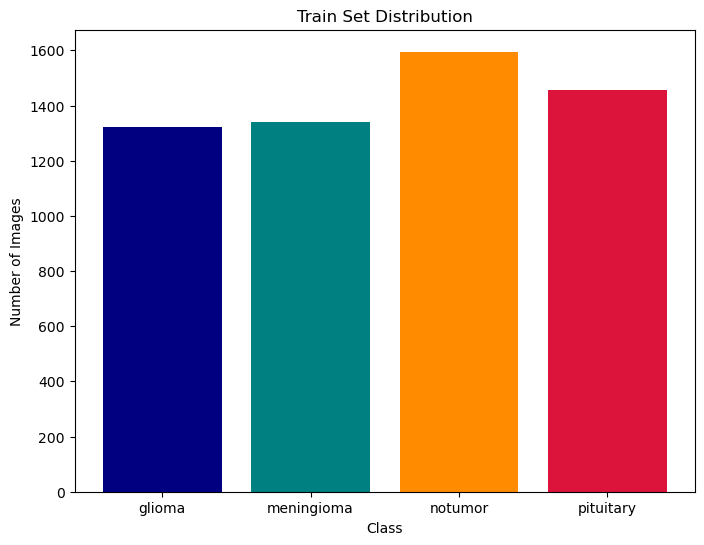

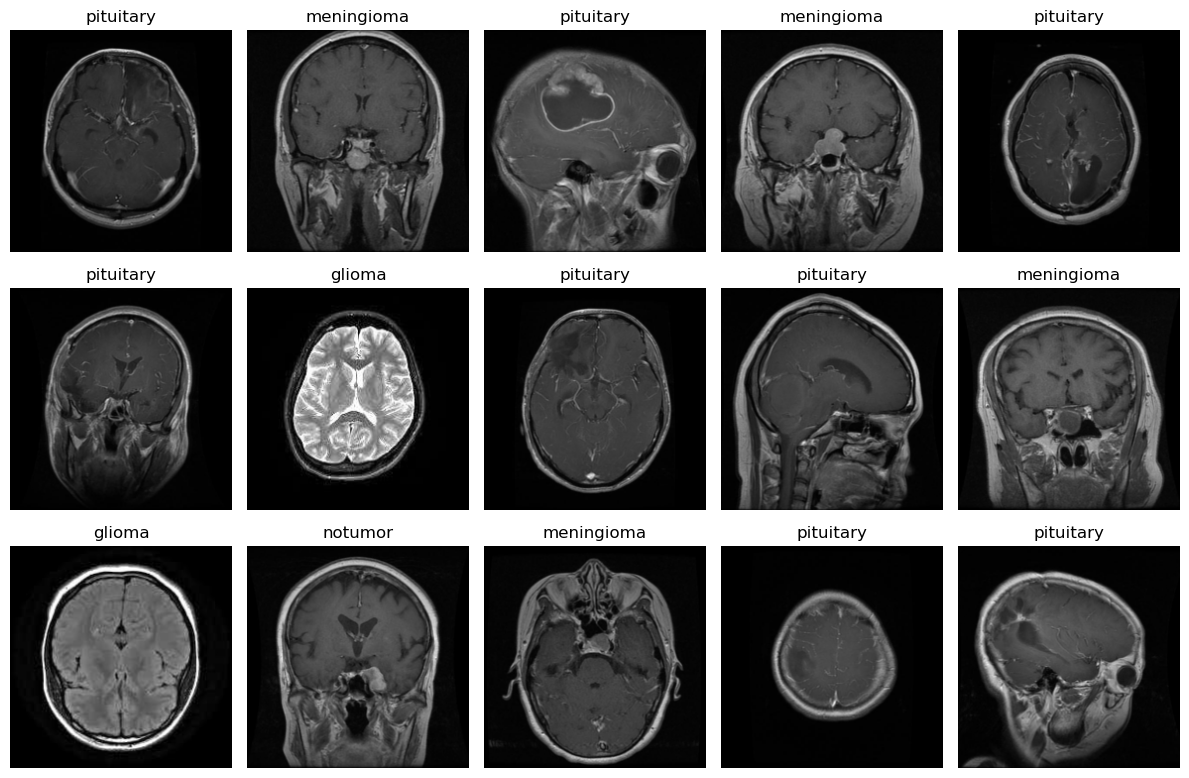

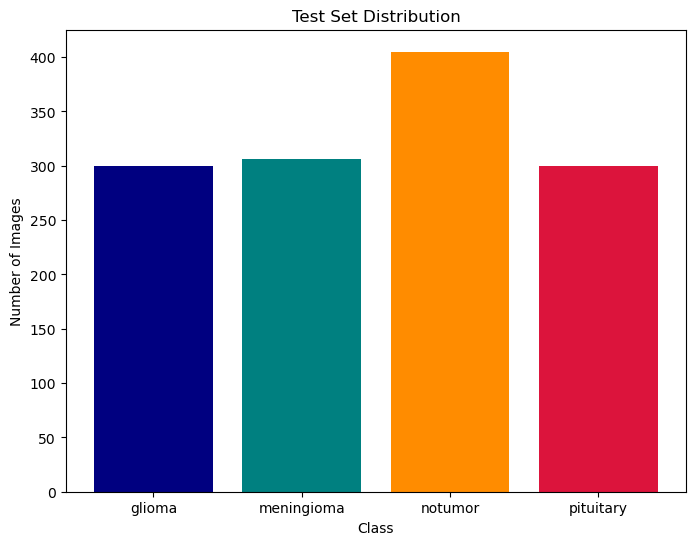

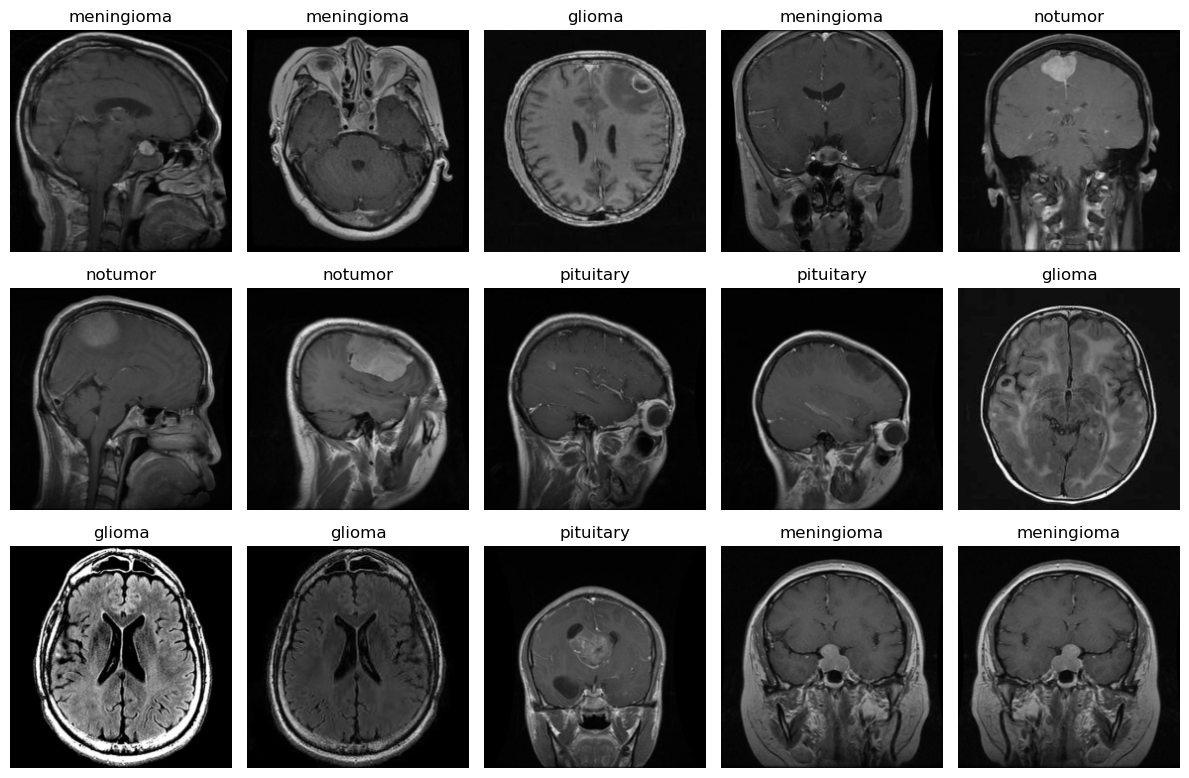

In [66]:
plot_class_distribution(train_dataset, "Train")
show_transformed_images(train_dataset)
plot_class_distribution(test_dataset, "Test")
show_transformed_images(test_dataset)

### Data Inbalance
As we can see our images dataset is a little bit inbalanced- we have more **no tumor** image samples. In the next stages of the project we will increase the number of samples, with two techniques:
1. Data augmentation
2. Generative Adversarial Networks called GANs

And then we will compare those methods (maybe we will combine them) and see which one is more effective.


# Data Augmentation

## Setting the Transformers

In [67]:
transformer = {
    'dataset1' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.05,0.05), fill=0),
        transforms.RandomRotation(10, fill=0),
        transforms.Grayscale(num_output_channels=1)
    ]),
    
    'dataset2' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.85, 1.1)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.07,0.07), fill=0),
        transforms.RandomRotation(10, fill=0),
        transforms.Grayscale(num_output_channels=1)
    ]),
    
    'dataset3' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224, scale=(0.85, 1.0), ratio=(0.8, 1.15)),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomAffine(degrees=0, translate=(0.1,0.1), fill=0),
        transforms.RandomRotation(15, fill=0),
        transforms.Grayscale(num_output_channels=1)
    ])
}

## Create augmented images

In [68]:
# desired number of images for each tumor type
DESIRED_IMG = 4000

# directory for augmented images
train_aug_dir = Path('data/tumors/brain_tumors_img/Training_augmented')

In [69]:
def create_dir(input_dir, output_dir):
    # create folder for new images
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # create subfolders for each label
    for label in CLASS_NAMES:
        input_subfolder = input_dir / label
        output_subfolder = output_dir / label
        os.makedirs(output_subfolder, exist_ok=True)
        
        # copy images from input_dir to output_dir
        os.path.isdir(input_subfolder)
        for filename in os.listdir(input_subfolder):
            input_path = os.path.join(input_subfolder, filename)
            output_path = os.path.join(output_subfolder, filename)
            if os.path.isfile(input_path) and not os.path.exists(output_path):
                shutil.copy2(input_path, output_path)
              


def image_augmentation(input_dir, output_dir):
    # create folder to save the images
    create_dir(input_dir, output_dir)
    
    for label in CLASS_NAMES:
        img_folder = output_dir / label
        existing_img = list(img_folder.glob('*.jpg'))
        num_existing_img = len(existing_img) # number of images in each label
        num_to_generate = DESIRED_IMG - num_existing_img # count how many images has to be augmented

        if num_to_generate <= 0:
            print(f"{label}: already has desired {num_existing_img} augmented images, skipping augmentation.")
            continue
        else: 
            print(f"Augmenting '{label}': need {num_to_generate} more images...")
            # image augmentation
            for i in range(num_to_generate):
                img_path = random.choice(existing_img)
                img = Image.open(img_path)
                key = random.choice(list(transformer.keys()))
                aug_img = transformer[key](img)
                save_path = img_folder / f"{label}_aug_{i + 1}.jpg"
                aug_img.save(save_path)

            print(f"Saved {num_to_generate} images to: {img_folder}. \n")

In [70]:
image_augmentation(train_dir, train_aug_dir)

glioma: already has desired 4000 augmented images, skipping augmentation.
meningioma: already has desired 4000 augmented images, skipping augmentation.
notumor: already has desired 4000 augmented images, skipping augmentation.
pituitary: already has desired 4000 augmented images, skipping augmentation.


In [71]:
print("Number of images in the training set:")
print("Pituitary: ", len(os.listdir(train_aug_dir / 'pituitary')))
print("No tumor: ", len(os.listdir(train_aug_dir / 'notumor')))
print("Glioma: ", len(os.listdir(train_aug_dir / 'glioma')))
print("Meningioma: ", len(os.listdir(train_aug_dir / 'meningioma')), '\n')

Number of images in the training set:
Pituitary:  4000
No tumor:  4000
Glioma:  4000
Meningioma:  4000 



### Load augmented images

In [72]:
train_aug_dataset, train_aug_loader = load_data(train_aug_dir)

### Data vizualization

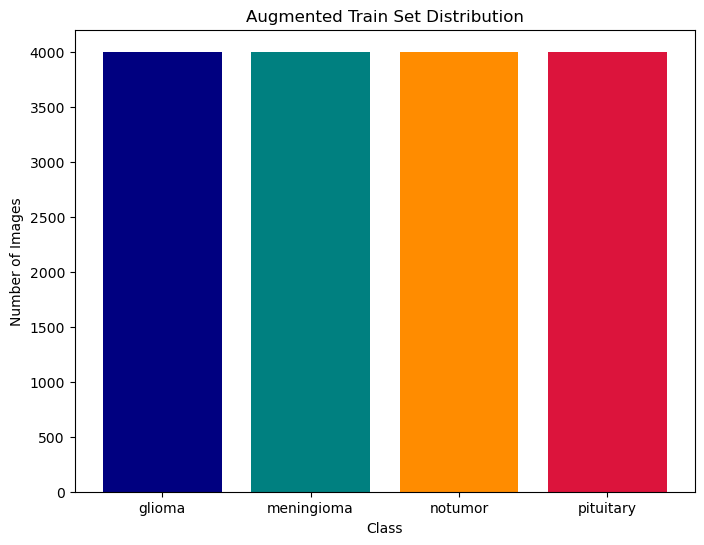

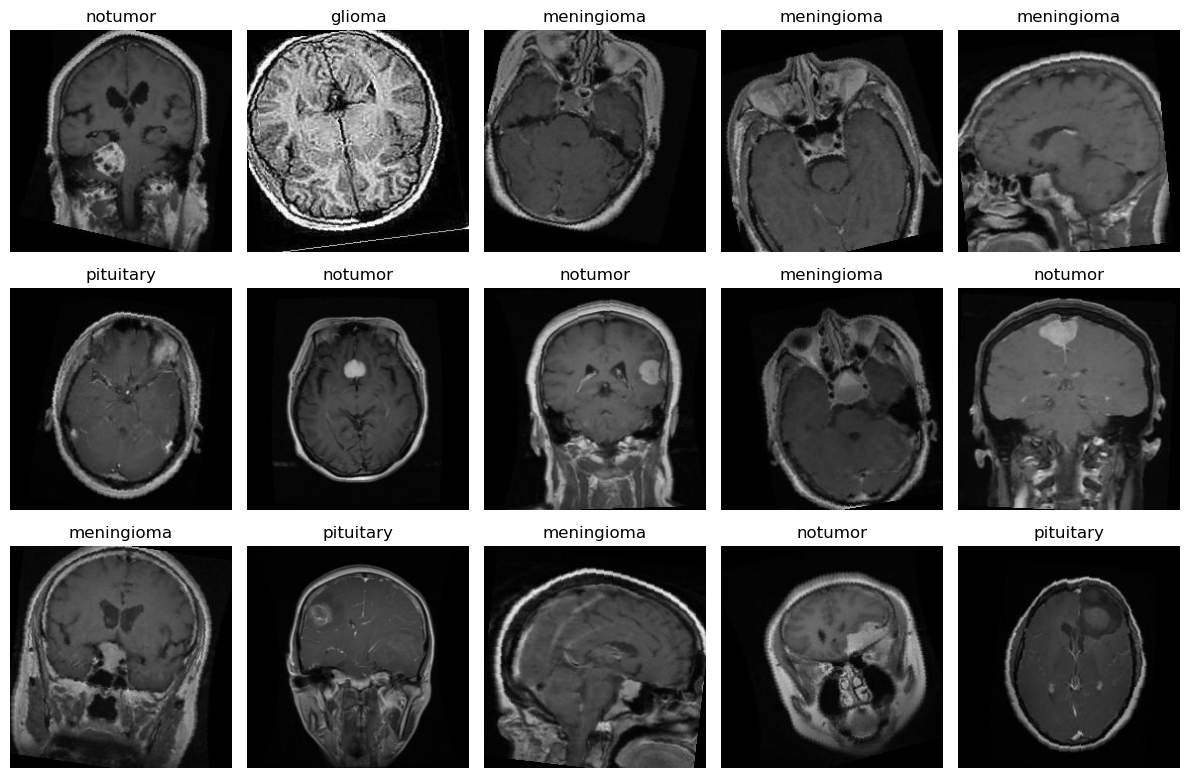

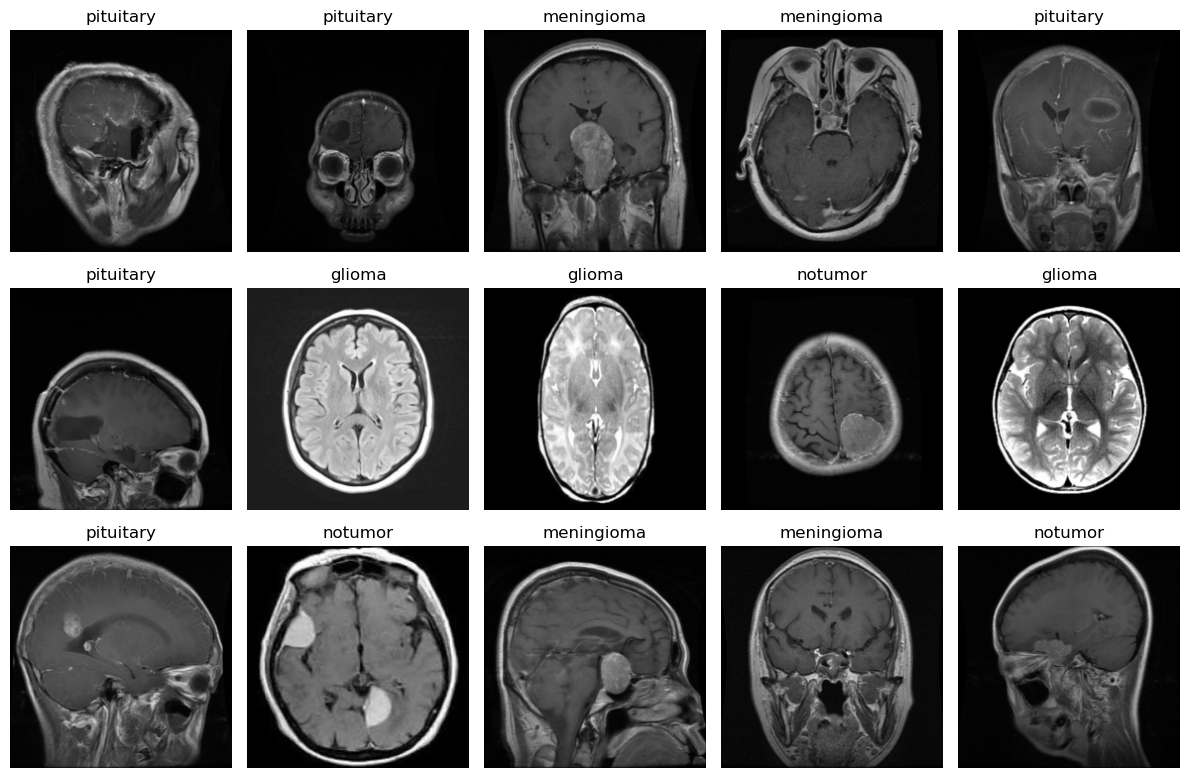

In [73]:
plot_class_distribution(train_aug_dataset, "Augmented Train")
show_transformed_images(train_aug_dataset)
show_transformed_images(train_dataset)

# Generative Adversarial Networks (GAN)

# Define the model


## Models architecture

### simple CNN 

In [78]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.flatten  = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)
        
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

### ResNet model

### VGG model

## Training models

In [82]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

## Model evaluation

In [83]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) # outputs.data, 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Model overview

## Simple CNN

### Training

In [86]:
epochs = 25
simple_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

print("Simple CNN model without augmentation")
for epoch in range(epochs):
    loss = train_model(simple_model, train_loader, criterion, optimizer, device)
    print(f"Epoch: {epoch}: Loss = {loss:.4f}")
    
accuracy = evaluate_model(simple_model, test_loader, device)
print(f"Accuracy: {accuracy:.4f}%")


print("\nSimple CNN model with augmentation")
for epoch in range(epochs):
    loss = train_model(simple_model, train_aug_loader, criterion, optimizer, device)
    print(f"Epoch: {epoch}: Loss = {loss:.4f}")
    
accuracy = evaluate_model(simple_model, test_loader, device)
print(f"Accuracy: {accuracy:.4f}%")


Simple CNN model without augmentation
Epoch: 0: Loss = 0.7730
Epoch: 1: Loss = 0.4046
Epoch: 2: Loss = 0.3029
Epoch: 3: Loss = 0.2311
Epoch: 4: Loss = 0.1790
Epoch: 5: Loss = 0.1391
Epoch: 6: Loss = 0.1053
Epoch: 7: Loss = 0.1023
Epoch: 8: Loss = 0.0732
Epoch: 9: Loss = 0.0702
Epoch: 10: Loss = 0.0623
Epoch: 11: Loss = 0.0498
Epoch: 12: Loss = 0.0701
Epoch: 13: Loss = 0.0433
Epoch: 14: Loss = 0.0471
Epoch: 15: Loss = 0.0423
Epoch: 16: Loss = 0.0299
Epoch: 17: Loss = 0.0335
Epoch: 18: Loss = 0.0280
Epoch: 19: Loss = 0.0505
Epoch: 20: Loss = 0.0485
Epoch: 21: Loss = 0.0312
Epoch: 22: Loss = 0.0173
Epoch: 23: Loss = 0.0303
Epoch: 24: Loss = 0.0224
Accuracy: 96.5675%

Simple CNN model with augmentation
Epoch: 0: Loss = 0.4610
Epoch: 1: Loss = 0.2797
Epoch: 2: Loss = 0.2026
Epoch: 3: Loss = 0.1425
Epoch: 4: Loss = 0.1072
Epoch: 5: Loss = 0.0865
Epoch: 6: Loss = 0.0729
Epoch: 7: Loss = 0.0595
Epoch: 8: Loss = 0.0576
Epoch: 9: Loss = 0.0511
Epoch: 10: Loss = 0.0581
Epoch: 11: Loss = 0.0458
Ep

## Saving the model